In [10]:
# load relevant packages
from pypdf import PdfReader
import os
import re
import pandas as pd
import numpy as np
from autocorrect import spell 
import matplotlib.pyplot as plt

# Set option to display all rows
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

# Questionnaire Parsing and Formatting

In [12]:
# read in pdf questionnaire and convert it to txt

# creating a pdf reader object 
reader = PdfReader('../World Value Survey/WVS_7_Codebook_Core_Variables.pdf') 
  
# printing number of pages in pdf file 
print("Length of Questionnaire: ", len(reader.pages)) 
  
# getting a specific page from the pdf file 
page = reader.pages[0] 

content = "------------- Content of Questionnaire -------------"
# extracting text from page 
for i in range(0,len(reader.pages)):
    content = content + "\n" + reader.pages[i].extract_text() 
    
#print(content)
 

Length of Questionnaire:  74


### Extraction Method: Regular Expression

In [13]:
# extract relevant information from questions Q1 - Q290 in WVS

# Define the pattern using regular expression
pattern = re.compile(r'Q\d+.*?(?=Q\d+|$)', re.DOTALL)


# Find all matches
matches = pattern.findall(content)
filtered_matches = [match.strip() for match in matches if len(match.strip()) >= 10]

In [14]:
# create dataframe
questionnaire = pd.DataFrame({
    "question": [np.nan] * len(filtered_matches), 
    "answer options": [np.nan] * len(filtered_matches),
    "list_answer_options": [np.nan] * len(filtered_matches)
    })

# irrelevant substrings
substring = r'\d+\s+The WORLD VALUES SURVEY ASSOCIATION \nwww.worldvaluessurvey.org'

for i,k in enumerate(filtered_matches):
    k = re.sub(substring, "", k)
    split_string = re.split("(\n1|\n2|\n 0.|\n 1.-|\n 10.-)", k, maxsplit=1)
    try:
        questionnaire["question"][i] = split_string[0]
        questionnaire["answer options"][i] = split_string[1] + split_string[2]
    except:
        print("An exception occurred. This might be a follow up question which was parsed incorrectly.")
        
questionnaire["answer options"] = questionnaire["answer options"].str.replace("\n", "")
questionnaire["question"] = questionnaire["question"].str.replace("\n", "")

# Extract the question ID using regex and create a new column
questionnaire['question_ID'] = questionnaire['question'].str.extract(r'(Q\d+)')
questionnaire['full_question_ID'] = questionnaire['question'].str.extract(r'(Q\d+\w*)')

questionnaire['question'] = questionnaire['question'].str.replace(r'(Q\d+\w*)\s* ', '', regex=True)

An exception occurred. This might be a follow up question which was parsed incorrectly.
An exception occurred. This might be a follow up question which was parsed incorrectly.
An exception occurred. This might be a follow up question which was parsed incorrectly.
An exception occurred. This might be a follow up question which was parsed incorrectly.
An exception occurred. This might be a follow up question which was parsed incorrectly.
An exception occurred. This might be a follow up question which was parsed incorrectly.
An exception occurred. This might be a follow up question which was parsed incorrectly.
An exception occurred. This might be a follow up question which was parsed incorrectly.
An exception occurred. This might be a follow up question which was parsed incorrectly.
An exception occurred. This might be a follow up question which was parsed incorrectly.
An exception occurred. This might be a follow up question which was parsed incorrectly.
An exception occurred. This migh

C:\Users\ruppr\AppData\Local\Temp\ipykernel_8784\2169306055.py:15: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  questionnaire["question"][i] = split_string[0]
C:\Users\ruppr\AppData\Local\Temp\ipykernel_8784\2169306055.py:15: FutureWarning:

#### Autocorrection for questions

In [15]:
import re
from symspellpy.symspellpy import SymSpell, Verbosity

# Initialize SymSpell object
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)

# Load the frequency dictionary
dictionary_path = "../World Value Survey/frequency_dictionary_en_82_765.txt"
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

# Load the bigram dictionary
bigram_path = "../World Value Survey/frequency_bigramdictionary_en_243_342.txt"
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)

split_pattern = re.compile(r'([^\w\s]+)')
list_delimiters = [",", ":", ".", "?", "!", ";"]

def correct_sentence(sentence):
    # Split the sentence by non-character delimiters while keeping the delimiters
    tokens = split_pattern.split(sentence)
    #print(tokens)
    corrected_sentence = []
    
    for token in tokens:
        if token in list_delimiters:
            corrected_sentence.append(token + " ")
        else:
            suggestions = sym_spell.lookup_compound(token, max_edit_distance=2,transfer_casing=True)
            corrected_sentence.append(suggestions[0].term if suggestions else token)
    
    return "".join(corrected_sentence)


In [16]:
# correct question column

for i,k in enumerate(questionnaire["question"]):
    corrected_sentence = correct_sentence(k)
    questionnaire["question"][i] = corrected_sentence

C:\Users\ruppr\AppData\Local\Temp\ipykernel_8784\2444160430.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  questionnaire["question"][i] = corrected_sentence
C:\Users\ruppr\AppData\Local\Temp\ipykernel_8784\2444160430.py:5: SettingWithCo

In [17]:
# create answer option lists

def extract_content_with_delimiters(text):
    pattern = r'(-?\d+)(.*?)(?=-?\d|$)'
    matches = re.findall(pattern, text)
    results = []

    for match in matches:
        current_number = match[0]
        content = match[1]
        results.append(f'{current_number}{content}')

    return results


for i,k in enumerate(questionnaire["answer options"]):
    try:
        questionnaire["list_answer_options"][i] = extract_content_with_delimiters(k)
    except:
        print(f"An error occured with parsing the content of row {i} with content {k}")



An error occured with parsing the content of row 114 with content nan
An error occured with parsing the content of row 117 with content nan
An error occured with parsing the content of row 120 with content nan
An error occured with parsing the content of row 123 with content nan
An error occured with parsing the content of row 126 with content nan
An error occured with parsing the content of row 129 with content nan
An error occured with parsing the content of row 132 with content nan
An error occured with parsing the content of row 135 with content nan
An error occured with parsing the content of row 138 with content nan
An error occured with parsing the content of row 141 with content nan
An error occured with parsing the content of row 144 with content nan
An error occured with parsing the content of row 147 with content nan
An error occured with parsing the content of row 216 with content nan
An error occured with parsing the content of row 268 with content nan
An error occured wit

C:\Users\ruppr\AppData\Local\Temp\ipykernel_8784\3543041009.py:18: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  questionnaire["list_answer_options"][i] = extract_content_with_delimiters(k)
C:\Users\ruppr\AppData\Local\Temp\ipykernel_8784\35

In [18]:
print("The uncleaned questionnaire contains: ", questionnaire.shape[0], " rows.")

# we have to remove nan cells due to incorrect parsing and because the questions are not relevant
questionnaire = questionnaire.dropna(subset=['question', 'answer options'])
print("The uncleaned questionnaire contains: ", questionnaire.shape[0], " rows.")

The uncleaned questionnaire contains:  308  rows.
The uncleaned questionnaire contains:  292  rows.


# Descriptive Statistics of WVS questionnaire
In this section I am exploring the structure of the WVS questionnaire and the information I extracted in the section above. This is needed and helpful for creating the perturbations reliably.

In [19]:
import pdfplumber
pdf = pdfplumber.open("../World Value Survey/WVS7_Explanatory_note_on_scales_recoding.pdf")
levels = []

for i in range(1, len(pdf.pages)):
    page =  pdf.pages[i]
    table = page.extract_table()
    levels.append(table)
    
cleaned_levels = []
for p in range(0,len(levels)):
    for i in levels[p]:
        if i[0] == "":
            print("Header detected and not added.")
        else:
            try: 
                new_list = [x for x in i if x not in ["", None]]
                cleaned_levels.append(new_list)
                print("List appended.")
            except: "List was already deleted."
        
    
#cleaned_levels

Header detected and not added.
List appended.
List appended.
List appended.
List appended.
List appended.
List appended.
List appended.
List appended.
List appended.
List appended.
List appended.
List appended.
List appended.
List appended.
List appended.
Header detected and not added.
List appended.
List appended.
List appended.
List appended.
List appended.
List appended.
List appended.
List appended.
Header detected and not added.
List appended.
List appended.
List appended.
List appended.
List appended.
List appended.
List appended.
List appended.
List appended.
Header detected and not added.
List appended.
List appended.
List appended.
List appended.
List appended.
List appended.
List appended.
List appended.
List appended.
List appended.
List appended.
List appended.
Header detected and not added.
List appended.
List appended.
List appended.
List appended.
List appended.
List appended.
List appended.
List appended.
Header detected and not added.
List appended.
List appended.
List

In [20]:
columns = ["ID", "Variables","Original scale", "Recoded “positive” scale", ""]
scales = pd.DataFrame(cleaned_levels, columns=columns)
for column in columns:
    scales[column] = scales[column].str.replace("\n", " ")
scales = scales.iloc[:,:4]

In [21]:
scales["list_answer_options"] = np.nan * scales.shape[0]


for i,k in enumerate(scales["Original scale"]):
    try:
        scales["list_answer_options"][i] = extract_content_with_delimiters(k)
    except:
        print(f"An error occured with parsing the content of row {i} with content {k}")

C:\Users\ruppr\AppData\Local\Temp\ipykernel_8784\379051486.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  scales["list_answer_options"][i] = extract_content_with_delimiters(k)
C:\Users\ruppr\AppData\Local\Temp\ipykernel_8784\379051486.p

In [22]:
scales["applies_to"] = np.nan * scales.shape[0]


for i,k in enumerate(scales["ID"]):
    try:
        k = k[1:]
        prefix, range_str = k.split("-")
        start = int(prefix)
        end = int(range_str)
        scales["applies_to"][i] = ["Q" + str(i) for i in range(start, end + 1)]
    except:
        scales["applies_to"][i] = "Q" + k
        #print(f"Applies to a single question.")


C:\Users\ruppr\AppData\Local\Temp\ipykernel_8784\3314279270.py:10: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  scales["applies_to"][i] = ["Q" + str(i) for i in range(start, end + 1)]
C:\Users\ruppr\AppData\Local\Temp\ipykernel_8784\3314279

In [23]:
scales = scales.explode(column="applies_to")
scales = scales.reset_index()

# for some questions we need to use the extracted answers from the codebook, not from the explanatory notes
for i,k in enumerate(scales["list_answer_options"]):
    if len(k) == 1:
        id = scales["applies_to"][i]
        scales["list_answer_options"][i] = questionnaire[questionnaire["question_ID"] == id]["list_answer_options"].iloc[0]
    else:
        k = k
    

C:\Users\ruppr\AppData\Local\Temp\ipykernel_8784\2948886254.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  scales["list_answer_options"][i] = questionnaire[questionnaire["question_ID"] == id]["list_answer_options"].iloc[0]
C:\Users\rupp

## Descriptive Analysis
The following is a short descriptive analysis of the answer options used within the WVS. 

In [26]:
# create a dataframe just containing the core variables
core_variables = scales.iloc[0:259]
core_variables.to_csv("../assets/core_variables.csv")

### Top 10 answer options in the core variables

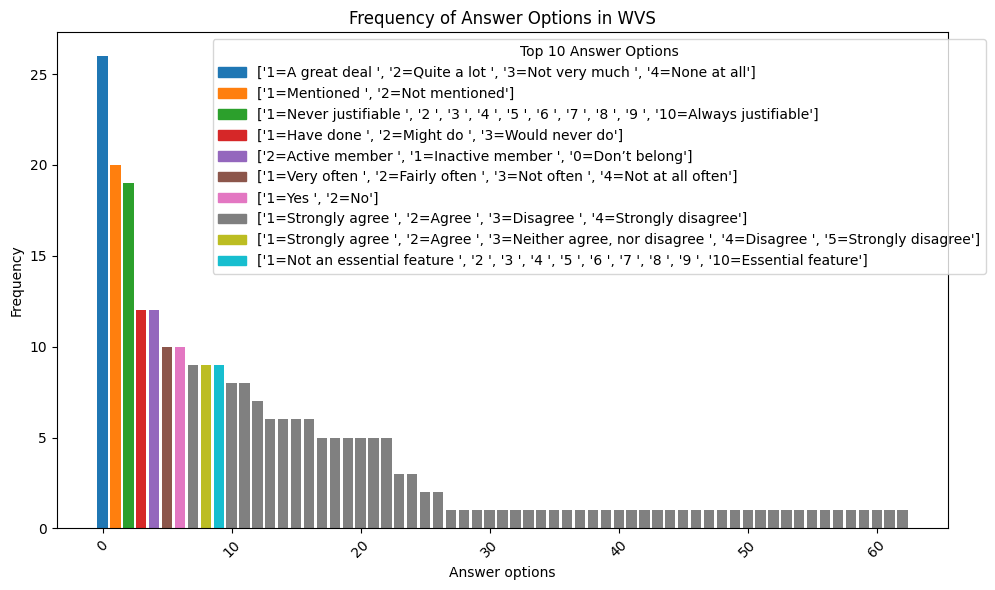

In [27]:
# Assuming 'core_variables' is your DataFrame and 'list_answer_options' is the column of interest

# Calculate frequency of each unique value
frequency = core_variables["list_answer_options"].value_counts()

# Get the top 10 most frequent values
top_10_frequency = frequency[0:10]

# Convert the index to a hashable type if necessary
top_10_index = [tuple(item) if isinstance(item, list) else item for item in top_10_frequency.index]

# Define a color map (e.g., 10 distinct colors)
colors = plt.cm.tab10(range(10))

# Create a dictionary mapping the top 10 values to colors
color_mapping = dict(zip(top_10_index, colors))

# Create a list of colors for the bars, converting index values to hashable types as necessary
bar_colors = [color_mapping.get(tuple(val) if isinstance(val, list) else val, 'grey') for val in frequency.index]

# Create a bar plot of the frequencies with colors for the top 10 values
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(frequency)), frequency.values, color=bar_colors)
plt.title('Frequency of Answer Options in WVS')
plt.xlabel('Answer options')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

# Create legend entries for the top 10 values
handles = [plt.Rectangle((0,0),1,1, color=color_mapping[val]) for val in top_10_index]
labels = top_10_frequency.index

# Add the legend to the plot
plt.legend(handles, labels, title="Top 10 Answer Options", bbox_to_anchor=(1.05, 1), loc='upper right', prop={'size': 10})

# Show the plot
plt.tight_layout()
plt.show()

### Top 10-20 answer options in the core variables

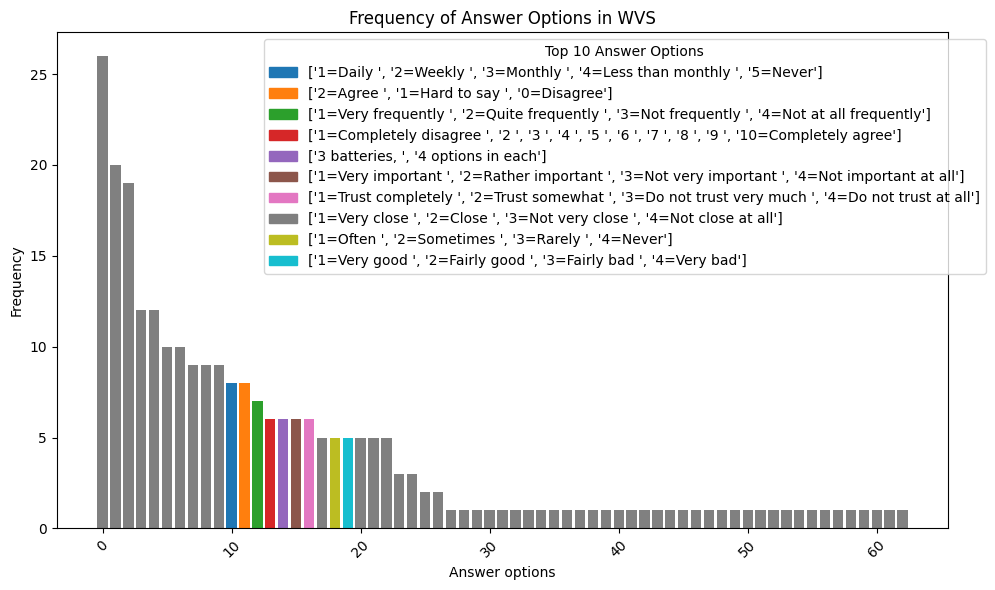

In [28]:
# Assuming 'core_variables' is your DataFrame and 'list_answer_options' is the column of interest

# Calculate frequency of each unique value
frequency = core_variables["list_answer_options"].value_counts()

# Get the top 10 most frequent values
top_10_frequency = frequency[10:20]

# Convert the index to a hashable type if necessary
top_10_index = [tuple(item) if isinstance(item, list) else item for item in top_10_frequency.index]

# Define a color map (e.g., 10 distinct colors)
colors = plt.cm.tab10(range(10))

# Create a dictionary mapping the top 10 values to colors
color_mapping = dict(zip(top_10_index, colors))

# Create a list of colors for the bars, converting index values to hashable types as necessary
bar_colors = [color_mapping.get(tuple(val) if isinstance(val, list) else val, 'grey') for val in frequency.index]

# Create a bar plot of the frequencies with colors for the top 10 values
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(frequency)), frequency.values, color=bar_colors)
plt.title('Frequency of Answer Options in WVS')
plt.xlabel('Answer options')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

# Create legend entries for the top 10 values
handles = [plt.Rectangle((0,0),1,1, color=color_mapping[val]) for val in top_10_index]
labels = top_10_frequency.index

# Add the legend to the plot
plt.legend(handles, labels, title="Top 10 Answer Options", bbox_to_anchor=(1.05, 1), loc='upper right', prop={'size': 10})

# Show the plot
plt.tight_layout()
plt.show()

# Perturbation

## Perturbation 1: Option Ordering
Here I are changing the order of the answer options. Primarily I am interested in changing the order of the options so that the prior first option becomes the last and vice versa.

In [29]:
df_option_order = scales
df_option_order["list_answer_options_recoded"] = np.nan * df_option_order.shape[0]


for i,k in enumerate(df_option_order["Recoded “positive” scale"]):
    try:
        df_option_order["list_answer_options_recoded"][i] = extract_content_with_delimiters(k)
    except:
        print(f"An error occured with parsing the content of row {i} with content {k}")

C:\Users\ruppr\AppData\Local\Temp\ipykernel_8784\3639133929.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_option_order["list_answer_options_recoded"][i] = extract_content_with_delimiters(k)
C:\Users\ruppr\AppData\Local\Temp\ipykerne

In [30]:
# include refusal categories in every list
# answer option "-3-.- Not applicable (no first answer)" is left out because it occurs just 4 times
refusals = ["-1=Don´t know", "-2=No answer", "-4=Not asked in this country", "-5=Missing; Not available"]

def extend_with_refusals(lst):
    return lst + refusals

# Apply the function to relevant columns
df_option_order['list_answer_options'] = df_option_order['list_answer_options'].apply(extend_with_refusals)
df_option_order['list_answer_options_recoded'] = df_option_order['list_answer_options_recoded'].apply(extend_with_refusals)

In [31]:
# explode the applies_to column to prepare to merge it to the questionnaire
df_option_order = df_option_order.explode("applies_to")
questionnaire_option_order = pd.merge(questionnaire[["question_ID", "full_question_ID", "question"]], df_option_order[["applies_to", "Variables", "Original scale","list_answer_options", "list_answer_options_recoded"]], left_on = "question_ID", right_on = "applies_to", how = "left")
questionnaire_option_order.head()

,question_ID,full_question_ID,question,applies_to,Variables,Original scale,list_answer_options,list_answer_options_recoded
0,Q1,Q1,"Important in life: Family For each of the following aspects, indicate how important it is in your life. Would you say it is very important, rather important, not very important or not important at all? Family",Q1,"Importance of family, friends, work, politics, religion",1=Very important 2=Rather important 3=Not very important 4=Not important at all,"[1=Very important , 2=Rather important , 3=Not very important , 4=Not important at all, -1=Don´t know, -2=No answer, -4=Not asked in this country, -5=Missing; Not available]","[4=Very important , 3=Rather important , 2=Not very important , 1=Not important at all, -1=Don´t know, -2=No answer, -4=Not asked in this country, -5=Missing; Not available]"
1,Q2,Q2,"Important in life: Friends For each of the following aspects, indicate how important it is in your life. Would you say it is very important, rather important, not very important or not important at all? Friends",Q2,"Importance of family, friends, work, politics, religion",1=Very important 2=Rather important 3=Not very important 4=Not important at all,"[1=Very important , 2=Rather important , 3=Not very important , 4=Not important at all, -1=Don´t know, -2=No answer, -4=Not asked in this country, -5=Missing; Not available]","[4=Very important , 3=Rather important , 2=Not very important , 1=Not important at all, -1=Don´t know, -2=No answer, -4=Not asked in this country, -5=Missing; Not available]"
2,Q3,Q3,"Important in life: Leisure time For each of the following aspects, indicate how important it is in your life. Would you say it is very important, rather important, not very important or not important at all? Leisure time",Q3,"Importance of family, friends, work, politics, religion",1=Very important 2=Rather important 3=Not very important 4=Not important at all,"[1=Very important , 2=Rather important , 3=Not very important , 4=Not important at all, -1=Don´t know, -2=No answer, -4=Not asked in this country, -5=Missing; Not available]","[4=Very important , 3=Rather important , 2=Not very important , 1=Not important at all, -1=Don´t know, -2=No answer, -4=Not asked in this country, -5=Missing; Not available]"
3,Q4,Q4,"Important in life: Politics For each of the following aspects, indicate how important it is in your life. Would you say it is very important, rather important, not very important or not important at all? Politics",Q4,"Importance of family, friends, work, politics, religion",1=Very important 2=Rather important 3=Not very important 4=Not important at all,"[1=Very important , 2=Rather important , 3=Not very important , 4=Not important at all, -1=Don´t know, -2=No answer, -4=Not asked in this country, -5=Missing; Not available]","[4=Very important , 3=Rather important , 2=Not very important , 1=Not important at all, -1=Don´t know, -2=No answer, -4=Not asked in this country, -5=Missing; Not available]"
4,Q5,Q5,"Important in life: Work For each of the following aspects, indicate how important it is in your life. Would you say it is very important, rather important, not very important or not important at all? Work",Q5,"Importance of family, friends, work, politics, religion",1=Very important 2=Rather important 3=Not very important 4=Not important at all,"[1=Very important , 2=Rather important , 3=Not very important , 4=Not important at all, -1=Don´t know, -2=No answer, -4=Not asked in this country, -5=Missing; Not available]","[4=Very important , 3=Rather important , 2=Not very important , 1=Not important at all, -1=Don´t know, -2=No answer, -4=Not asked in this country, -5=Missing; Not available]"


In [32]:
# different ordering technique
# Define the reverse_list function
def reverse_list(input_list):
    """
    This function takes a list as input and returns the list with elements in reversed order.
    """
    return input_list[::-1]

questionnaire_option_order["list_answer_options_reversed"] = questionnaire_option_order["list_answer_options"].apply(reverse_list)
questionnaire_option_order.head(2)

,question_ID,full_question_ID,question,applies_to,Variables,Original scale,list_answer_options,list_answer_options_recoded,list_answer_options_reversed
0,Q1,Q1,"Important in life: Family For each of the following aspects, indicate how important it is in your life. Would you say it is very important, rather important, not very important or not important at all? Family",Q1,"Importance of family, friends, work, politics, religion",1=Very important 2=Rather important 3=Not very important 4=Not important at all,"[1=Very important , 2=Rather important , 3=Not very important , 4=Not important at all, -1=Don´t know, -2=No answer, -4=Not asked in this country, -5=Missing; Not available]","[4=Very important , 3=Rather important , 2=Not very important , 1=Not important at all, -1=Don´t know, -2=No answer, -4=Not asked in this country, -5=Missing; Not available]","[-5=Missing; Not available, -4=Not asked in this country, -2=No answer, -1=Don´t know, 4=Not important at all, 3=Not very important , 2=Rather important , 1=Very important ]"
1,Q2,Q2,"Important in life: Friends For each of the following aspects, indicate how important it is in your life. Would you say it is very important, rather important, not very important or not important at all? Friends",Q2,"Importance of family, friends, work, politics, religion",1=Very important 2=Rather important 3=Not very important 4=Not important at all,"[1=Very important , 2=Rather important , 3=Not very important , 4=Not important at all, -1=Don´t know, -2=No answer, -4=Not asked in this country, -5=Missing; Not available]","[4=Very important , 3=Rather important , 2=Not very important , 1=Not important at all, -1=Don´t know, -2=No answer, -4=Not asked in this country, -5=Missing; Not available]","[-5=Missing; Not available, -4=Not asked in this country, -2=No answer, -1=Don´t know, 4=Not important at all, 3=Not very important , 2=Rather important , 1=Very important ]"


In [33]:
questionnaire_option_order.to_csv("../assets/questionnaire_perturbations/questionnaire_option_order.csv")

## Perturbation 2: Refusal Category
Here I create a dataframe which does not contain any refusal categories. Based on the question ID in the whole dataframe and the "applies_to" column, the scales are added to the corresponding question.

In [34]:
df_no_refusal = pd.DataFrame(scales)


df_no_refusal["list_answer_no_refusal"] = len(df_no_refusal)*np.nan

# remove refusal categories 
for i,k in enumerate(df_no_refusal["list_answer_options"]):
    df_no_refusal["list_answer_no_refusal"][i] = k[:-4]
df_no_refusal.head()

C:\Users\ruppr\AppData\Local\Temp\ipykernel_8784\4012837599.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_no_refusal["list_answer_no_refusal"][i] = k[:-4]
C:\Users\ruppr\AppData\Local\Temp\ipykernel_8784\4012837599.py:8: SettingWith

,index,ID,Variables,Original scale,Recoded “positive” scale,list_answer_options,applies_to,list_answer_options_recoded,list_answer_no_refusal
0,0,Q1-6,"Importance of family, friends, work, politics, religion",1=Very important 2=Rather important 3=Not very important 4=Not important at all,4=Very important 3=Rather important 2=Not very important 1=Not important at all,"[1=Very important , 2=Rather important , 3=Not very important , 4=Not important at all, -1=Don´t know, -2=No answer, -4=Not asked in this country, -5=Missing; Not available]",Q1,"[4=Very important , 3=Rather important , 2=Not very important , 1=Not important at all, -1=Don´t know, -2=No answer, -4=Not asked in this country, -5=Missing; Not available]","[1=Very important , 2=Rather important , 3=Not very important , 4=Not important at all]"
1,0,Q1-6,"Importance of family, friends, work, politics, religion",1=Very important 2=Rather important 3=Not very important 4=Not important at all,4=Very important 3=Rather important 2=Not very important 1=Not important at all,"[1=Very important , 2=Rather important , 3=Not very important , 4=Not important at all, -1=Don´t know, -2=No answer, -4=Not asked in this country, -5=Missing; Not available]",Q2,"[4=Very important , 3=Rather important , 2=Not very important , 1=Not important at all, -1=Don´t know, -2=No answer, -4=Not asked in this country, -5=Missing; Not available]","[1=Very important , 2=Rather important , 3=Not very important , 4=Not important at all]"
2,0,Q1-6,"Importance of family, friends, work, politics, religion",1=Very important 2=Rather important 3=Not very important 4=Not important at all,4=Very important 3=Rather important 2=Not very important 1=Not important at all,"[1=Very important , 2=Rather important , 3=Not very important , 4=Not important at all, -1=Don´t know, -2=No answer, -4=Not asked in this country, -5=Missing; Not available]",Q3,"[4=Very important , 3=Rather important , 2=Not very important , 1=Not important at all, -1=Don´t know, -2=No answer, -4=Not asked in this country, -5=Missing; Not available]","[1=Very important , 2=Rather important , 3=Not very important , 4=Not important at all]"
3,0,Q1-6,"Importance of family, friends, work, politics, religion",1=Very important 2=Rather important 3=Not very important 4=Not important at all,4=Very important 3=Rather important 2=Not very important 1=Not important at all,"[1=Very important , 2=Rather important , 3=Not very important , 4=Not important at all, -1=Don´t know, -2=No answer, -4=Not asked in this country, -5=Missing; Not available]",Q4,"[4=Very important , 3=Rather important , 2=Not very important , 1=Not important at all, -1=Don´t know, -2=No answer, -4=Not asked in this country, -5=Missing; Not available]","[1=Very important , 2=Rather important , 3=Not very important , 4=Not important at all]"
4,0,Q1-6,"Importance of family, friends, work, politics, religion",1=Very important 2=Rather important 3=Not very important 4=Not important at all,4=Very important 3=Rather important 2=Not very important 1=Not important at all,"[1=Very important , 2=Rather important , 3=Not very important , 4=Not important at all, -1=Don´t know, -2=No answer, -4=Not asked in this country, -5=Missing; Not available]",Q5,"[4=Very important , 3=Rather important , 2=Not very important , 1=Not important at all, -1=Don´t know, -2=No answer, -4=Not asked in this country, -5=Missing; Not available]","[1=Very important , 2=Rather important , 3=Not very important , 4=Not important at all]"


In [35]:
# explode the applies_to column to prepare to merge it to the questionnaire
df_no_refusal = df_no_refusal.explode("applies_to")

# merge on questions based on question ID
questionnaire_no_refusal = pd.merge(questionnaire[["question_ID", "full_question_ID", "question"]], df_no_refusal[["applies_to", "Variables", "Original scale","list_answer_options", "list_answer_no_refusal"]], left_on = "question_ID", right_on = "applies_to", how = "left")
questionnaire_no_refusal.head()

,question_ID,full_question_ID,question,applies_to,Variables,Original scale,list_answer_options,list_answer_no_refusal
0,Q1,Q1,"Important in life: Family For each of the following aspects, indicate how important it is in your life. Would you say it is very important, rather important, not very important or not important at all? Family",Q1,"Importance of family, friends, work, politics, religion",1=Very important 2=Rather important 3=Not very important 4=Not important at all,"[1=Very important , 2=Rather important , 3=Not very important , 4=Not important at all, -1=Don´t know, -2=No answer, -4=Not asked in this country, -5=Missing; Not available]","[1=Very important , 2=Rather important , 3=Not very important , 4=Not important at all]"
1,Q2,Q2,"Important in life: Friends For each of the following aspects, indicate how important it is in your life. Would you say it is very important, rather important, not very important or not important at all? Friends",Q2,"Importance of family, friends, work, politics, religion",1=Very important 2=Rather important 3=Not very important 4=Not important at all,"[1=Very important , 2=Rather important , 3=Not very important , 4=Not important at all, -1=Don´t know, -2=No answer, -4=Not asked in this country, -5=Missing; Not available]","[1=Very important , 2=Rather important , 3=Not very important , 4=Not important at all]"
2,Q3,Q3,"Important in life: Leisure time For each of the following aspects, indicate how important it is in your life. Would you say it is very important, rather important, not very important or not important at all? Leisure time",Q3,"Importance of family, friends, work, politics, religion",1=Very important 2=Rather important 3=Not very important 4=Not important at all,"[1=Very important , 2=Rather important , 3=Not very important , 4=Not important at all, -1=Don´t know, -2=No answer, -4=Not asked in this country, -5=Missing; Not available]","[1=Very important , 2=Rather important , 3=Not very important , 4=Not important at all]"
3,Q4,Q4,"Important in life: Politics For each of the following aspects, indicate how important it is in your life. Would you say it is very important, rather important, not very important or not important at all? Politics",Q4,"Importance of family, friends, work, politics, religion",1=Very important 2=Rather important 3=Not very important 4=Not important at all,"[1=Very important , 2=Rather important , 3=Not very important , 4=Not important at all, -1=Don´t know, -2=No answer, -4=Not asked in this country, -5=Missing; Not available]","[1=Very important , 2=Rather important , 3=Not very important , 4=Not important at all]"
4,Q5,Q5,"Important in life: Work For each of the following aspects, indicate how important it is in your life. Would you say it is very important, rather important, not very important or not important at all? Work",Q5,"Importance of family, friends, work, politics, religion",1=Very important 2=Rather important 3=Not very important 4=Not important at all,"[1=Very important , 2=Rather important , 3=Not very important , 4=Not important at all, -1=Don´t know, -2=No answer, -4=Not asked in this country, -5=Missing; Not available]","[1=Very important , 2=Rather important , 3=Not very important , 4=Not important at all]"


In [36]:
# save questionnaire with refusal perturbation
questionnaire_no_refusal.to_csv("../assets/questionnaire_perturbations/questionnaire_no_refusal.csv")

## Perturbation 3: Middle Category
Here I check whether the answer options contain a middle category and create a dataframe which avoids middle categories.

In [41]:
scales["list_answer_no_refusal"] = len(scales)*np.nan

# remove refusal categories 
for i,k in enumerate(scales["list_answer_options"]):
    scales["list_answer_no_refusal"][i] = k[:-4]
    

scales["len_answer_options"] = scales["list_answer_no_refusal"].apply(len)
scales["odd_answer_options"] = scales['len_answer_options'] % 2 != 0
scales[scales["odd_answer_options"] == False]

C:\Users\ruppr\AppData\Local\Temp\ipykernel_8784\3576738984.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  scales["list_answer_no_refusal"][i] = k[:-4]
C:\Users\ruppr\AppData\Local\Temp\ipykernel_8784\3576738984.py:5: SettingWithCopyWar

,index,ID,Variables,Original scale,Recoded “positive” scale,list_answer_options,applies_to,list_answer_options_recoded,list_answer_no_refusal,len_answer_options,odd_answer_options,list_answer_no_middle
0,0,Q1-6,"Importance of family, friends, work, politics, religion",1=Very important 2=Rather important 3=Not very important 4=Not important at all,4=Very important 3=Rather important 2=Not very important 1=Not important at all,"[1=Very important , 2=Rather important , 3=Not very important , 4=Not important at all, -1=Don´t know, -2=No answer, -4=Not asked in this country, -5=Missing; Not available]",Q1,"[4=Very important , 3=Rather important , 2=Not very important , 1=Not important at all, -1=Don´t know, -2=No answer, -4=Not asked in this country, -5=Missing; Not available]","[1=Very important , 2=Rather important , 3=Not very important , 4=Not important at all]",4,False,"[1=Very important , 2=Rather important , 3=Not very important , 4=Not important at all]"
1,0,Q1-6,"Importance of family, friends, work, politics, religion",1=Very important 2=Rather important 3=Not very important 4=Not important at all,4=Very important 3=Rather important 2=Not very important 1=Not important at all,"[1=Very important , 2=Rather important , 3=Not very important , 4=Not important at all, -1=Don´t know, -2=No answer, -4=Not asked in this country, -5=Missing; Not available]",Q2,"[4=Very important , 3=Rather important , 2=Not very important , 1=Not important at all, -1=Don´t know, -2=No answer, -4=Not asked in this country, -5=Missing; Not available]","[1=Very important , 2=Rather important , 3=Not very important , 4=Not important at all]",4,False,"[1=Very important , 2=Rather important , 3=Not very important , 4=Not important at all]"
2,0,Q1-6,"Importance of family, friends, work, politics, religion",1=Very important 2=Rather important 3=Not very important 4=Not important at all,4=Very important 3=Rather important 2=Not very important 1=Not important at all,"[1=Very important , 2=Rather important , 3=Not very important , 4=Not important at all, -1=Don´t know, -2=No answer, -4=Not asked in this country, -5=Missing; Not available]",Q3,"[4=Very important , 3=Rather important , 2=Not very important , 1=Not important at all, -1=Don´t know, -2=No answer, -4=Not asked in this country, -5=Missing; Not available]","[1=Very important , 2=Rather important , 3=Not very important , 4=Not important at all]",4,False,"[1=Very important , 2=Rather important , 3=Not very important , 4=Not important at all]"
3,0,Q1-6,"Importance of family, friends, work, politics, religion",1=Very important 2=Rather important 3=Not very important 4=Not important at all,4=Very important 3=Rather important 2=Not very important 1=Not important at all,"[1=Very important , 2=Rather important , 3=Not very important , 4=Not important at all, -1=Don´t know, -2=No answer, -4=Not asked in this country, -5=Missing; Not available]",Q4,"[4=Very important , 3=Rather important , 2=Not very important , 1=Not important at all, -1=Don´t know, -2=No answer, -4=Not asked in this country, -5=Missing; Not available]","[1=Very important , 2=Rather important , 3=Not very important , 4=Not important at all]",4,False,"[1=Very important , 2=Rather important , 3=Not very important , 4=Not important at all]"
4,0,Q1-6,"Importance of family, friends, work, politics, religion",1=Very important 2=Rather important 3=Not very important 4=Not important at all,4=Very important 3=Rather important 2=Not very important 1=Not important at all,"[1=Very important , 2=Rather important , 3=Not very important , 4=Not important at all, -1=Don´t know, -2=No answer, -4=Not asked in this country, -5=Missing; Not available]",Q5,"[4=Very important , 3=Rather important , 2=Not very important , 1=Not important at all, -1=Don´t know, -2=No answer, -4=Not asked in this country, -5=Missing; Not available]","[1=Very important , 2=Rather important , 3=Not very important , 4=Not important at all]",4,False,"[1=Very important , 2=Rather importan

In [38]:
options_to_change = ["Q33-41","Q43-45", "Q47","Q121", "Q122-129","Q209-220","Q287"]

# Function to remove the middle category from a list
def remove_middle_category(lst):
    if len(lst) % 2 == 1:  # Only if the list length is odd
        middle_index = len(lst) // 2
        del lst[middle_index]
    return lst

# Apply the function to the column based on the condition
scales['list_answer_no_middle'] = scales['list_answer_no_refusal']
scales['list_answer_no_middle'] = scales.apply(
    lambda row: remove_middle_category(row['list_answer_no_middle']) if row['ID'] in options_to_change else row['list_answer_no_refusal'],
    axis=1
)
scales[scales["odd_answer_options"] == True]


,index,ID,Variables,Original scale,Recoded “positive” scale,list_answer_options,applies_to,list_answer_options_recoded,list_answer_no_refusal,len_answer_options,odd_answer_options,list_answer_no_middle
32,4,Q33-41,Set of statements on social attitudes,"1=Strongly agree 2=Agree 3=Neither agree, nor disagree 4=Disagree 5=Strongly disagree","5=Strongly agree 4=Agree 3=Neither agree, nor disagree 2=Disagree 1=Strongly disagree","[1=Strongly agree , 2=Agree , 3=Neither agree, nor disagree , 4=Disagree , 5=Strongly disagree, -1=Don´t know, -2=No answer, -4=Not asked in this country, -5=Missing; Not available]",Q33,"[5=Strongly agree , 4=Agree , 3=Neither agree, nor disagree , 2=Disagree , 1=Strongly disagree, -1=Don´t know, -2=No answer, -4=Not asked in this country, -5=Missing; Not available]","[1=Strongly agree , 2=Agree , 4=Disagree , 5=Strongly disagree]",5,True,"[1=Strongly agree , 2=Agree , 4=Disagree , 5=Strongly disagree]"
33,4,Q33-41,Set of statements on social attitudes,"1=Strongly agree 2=Agree 3=Neither agree, nor disagree 4=Disagree 5=Strongly disagree","5=Strongly agree 4=Agree 3=Neither agree, nor disagree 2=Disagree 1=Strongly disagree","[1=Strongly agree , 2=Agree , 3=Neither agree, nor disagree , 4=Disagree , 5=Strongly disagree, -1=Don´t know, -2=No answer, -4=Not asked in this country, -5=Missing; Not available]",Q34,"[5=Strongly agree , 4=Agree , 3=Neither agree, nor disagree , 2=Disagree , 1=Strongly disagree, -1=Don´t know, -2=No answer, -4=Not asked in this country, -5=Missing; Not available]","[1=Strongly agree , 2=Agree , 4=Disagree , 5=Strongly disagree]",5,True,"[1=Strongly agree , 2=Agree , 4=Disagree , 5=Strongly disagree]"
34,4,Q33-41,Set of statements on social attitudes,"1=Strongly agree 2=Agree 3=Neither agree, nor disagree 4=Disagree 5=Strongly disagree","5=Strongly agree 4=Agree 3=Neither agree, nor disagree 2=Disagree 1=Strongly disagree","[1=Strongly agree , 2=Agree , 3=Neither agree, nor disagree , 4=Disagree , 5=Strongly disagree, -1=Don´t know, -2=No answer, -4=Not asked in this country, -5=Missing; Not available]",Q35,"[5=Strongly agree , 4=Agree , 3=Neither agree, nor disagree , 2=Disagree , 1=Strongly disagree, -1=Don´t know, -2=No answer, -4=Not asked in this country, -5=Missing; Not available]","[1=Strongly agree , 2=Agree , 4=Disagree , 5=Strongly disagree]",5,True,"[1=Strongly agree , 2=Agree , 4=Disagree , 5=Strongly disagree]"
35,4,Q33-41,Set of statements on social attitudes,"1=Strongly agree 2=Agree 3=Neither agree, nor disagree 4=Disagree 5=Strongly disagree","5=Strongly agree 4=Agree 3=Neither agree, nor disagree 2=Disagree 1=Strongly disagree","[1=Strongly agree , 2=Agree , 3=Neither agree, nor disagree , 4=Disagree , 5=Strongly disagree, -1=Don´t know, -2=No answer, -4=Not asked in this country, -5=Missing; Not available]",Q36,"[5=Strongly agree , 4=Agree , 3=Neither agree, nor disagree , 2=Disagree , 1=Strongly disagree, -1=Don´t know, -2=No answer, -4=Not asked in this country, -5=Missing; Not available]","[1=Strongly agree , 2=Agree , 4=Disagree , 5=Strongly disagree]",5,True,"[1=Strongly agree , 2=Agree , 4=Disagree , 5=Strongly disagree]"
36,4,Q33-41,Set of statements on social attitudes,"1=Strongly agree 2=Agree 3=Neither agree, nor disagree 4=Disagree 5=Strongly disagree","5=Strongly agree 4=Agree 3=Neither agree, nor disagree 2=Disagree 1=Strongly disagree","[1=Strongly agree , 2=Agree , 3=Neither agree, nor disagree , 4=Disagree , 5=Strongly disagree, -1=Don´t know, -2=No answer, -4=Not asked in this country, -5=Missing; Not available]",Q37,"[5=Strongly agree , 4=Agree , 3=Neither agree, nor disagree , 2=Disagree , 1=Strongly disagree, -1=Don´t know, -2=No answer, -4=Not asked in this country, -5=Missing; Not available]","[1=Strongly agree , 2=Agree , 4=Disagree , 5=Strongly disagree]",5,True,"[1=Strongly agree , 2=Agree , 4=Disagree , 5=Strongly disagree]"
37,4,Q33-41,Set of statements on social attitudes,"1=Strongly agree 2=Agree 3=Neither agree, nor disagree 4=Disag

In [42]:
# explode the applies_to column to prepare to merge it to the questionnaire
df_middle_cat = scales
df_middle_cat = df_middle_cat.explode("applies_to")

# merge on questions based on question ID
questionnaire_no_middle = pd.merge(questionnaire[["question_ID", "full_question_ID", "question"]], df_middle_cat[["applies_to", "Variables", "Original scale","list_answer_options", "list_answer_no_refusal", "len_answer_options", "odd_answer_options", "list_answer_no_middle"]], left_on = "question_ID", right_on = "applies_to", how = "left")
questionnaire_no_middle[questionnaire_no_middle["odd_answer_options"] == False]

,question_ID,full_question_ID,question,applies_to,Variables,Original scale,list_answer_options,list_answer_no_refusal,len_answer_options,odd_answer_options,list_answer_no_middle
0,Q1,Q1,"Important in life: Family For each of the following aspects, indicate how important it is in your life. Would you say it is very important, rather important, not very important or not important at all? Family",Q1,"Importance of family, friends, work, politics, religion",1=Very important 2=Rather important 3=Not very important 4=Not important at all,"[1=Very important , 2=Rather important , 3=Not very important , 4=Not important at all, -1=Don´t know, -2=No answer, -4=Not asked in this country, -5=Missing; Not available]","[1=Very important , 2=Rather important , 3=Not very important , 4=Not important at all]",4,False,"[1=Very important , 2=Rather important , 3=Not very important , 4=Not important at all]"
1,Q2,Q2,"Important in life: Friends For each of the following aspects, indicate how important it is in your life. Would you say it is very important, rather important, not very important or not important at all? Friends",Q2,"Importance of family, friends, work, politics, religion",1=Very important 2=Rather important 3=Not very important 4=Not important at all,"[1=Very important , 2=Rather important , 3=Not very important , 4=Not important at all, -1=Don´t know, -2=No answer, -4=Not asked in this country, -5=Missing; Not available]","[1=Very important , 2=Rather important , 3=Not very important , 4=Not important at all]",4,False,"[1=Very important , 2=Rather important , 3=Not very important , 4=Not important at all]"
2,Q3,Q3,"Important in life: Leisure time For each of the following aspects, indicate how important it is in your life. Would you say it is very important, rather important, not very important or not important at all? Leisure time",Q3,"Importance of family, friends, work, politics, religion",1=Very important 2=Rather important 3=Not very important 4=Not important at all,"[1=Very important , 2=Rather important , 3=Not very important , 4=Not important at all, -1=Don´t know, -2=No answer, -4=Not asked in this country, -5=Missing; Not available]","[1=Very important , 2=Rather important , 3=Not very important , 4=Not important at all]",4,False,"[1=Very important , 2=Rather important , 3=Not very important , 4=Not important at all]"
3,Q4,Q4,"Important in life: Politics For each of the following aspects, indicate how important it is in your life. Would you say it is very important, rather important, not very important or not important at all? Politics",Q4,"Importance of family, friends, work, politics, religion",1=Very important 2=Rather important 3=Not very important 4=Not important at all,"[1=Very important , 2=Rather important , 3=Not very important , 4=Not important at all, -1=Don´t know, -2=No answer, -4=Not asked in this country, -5=Missing; Not available]","[1=Very important , 2=Rather important , 3=Not very important , 4=Not important at all]",4,False,"[1=Very important , 2=Rather important , 3=Not very important , 4=Not important at all]"
4,Q5,Q5,"Important in life: Work For each of the following aspects, indicate how important it is in your life. Would you say it is very important, rather important, not very important or not important at all? Work",Q5,"Importance of family, friends, work, politics, religion",1=Very important 2=Rather important 3=Not very important 4=Not important at all,"[1=Very important , 2=Rather important , 3=Not very important , 4=Not important at all, -1=Don´t know, -2=No answer, -4=Not asked in this country, -5=Missing; Not available]","[1=Very important , 2=Rather important , 3=Not very important , 4=Not important at all]",4,False,"[1=Very important , 2=Rather important , 3=Not very important , 4=Not important at all]"
5,Q6,Q6,"Important in life: Religion For each of the following aspects, indicate how important it is in your life. Would you say it is very important, rather important, not very important 

In [40]:
# save questionnaire with refusal perturbation
questionnaire_no_middle.to_csv("../assets/questionnaire_perturbations/questionnaire_no_middle.csv")